In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
import pingouin as pg
import researchpy

import networkx as nx
from sklearn.preprocessing import StandardScaler

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
from adjustText import adjust_text # For nonoverlapping text labels on plots
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 30 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [27]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("Study1.xlsx"))
df.head()

,Country,Region,GGG,GGG_inverse,PercentF,PercentM,PercentWomen_population
0,Australia,AngloSaxon,0.731,0.269,0.363636,0.636364,50.201238
1,Austria,NandWEurope,0.744,0.256,0.430000,0.570000,50.710000
2,Belgium,NandWEurope,0.750,0.250,0.603960,0.396040,50.435502
3,Brazil,SouthAmerica,0.691,0.309,0.439560,0.560440,50.867485
4,Canada,AngloSaxon,0.772,0.228,0.333333,0.666667,50.368025


<IPython.core.display.Javascript object>


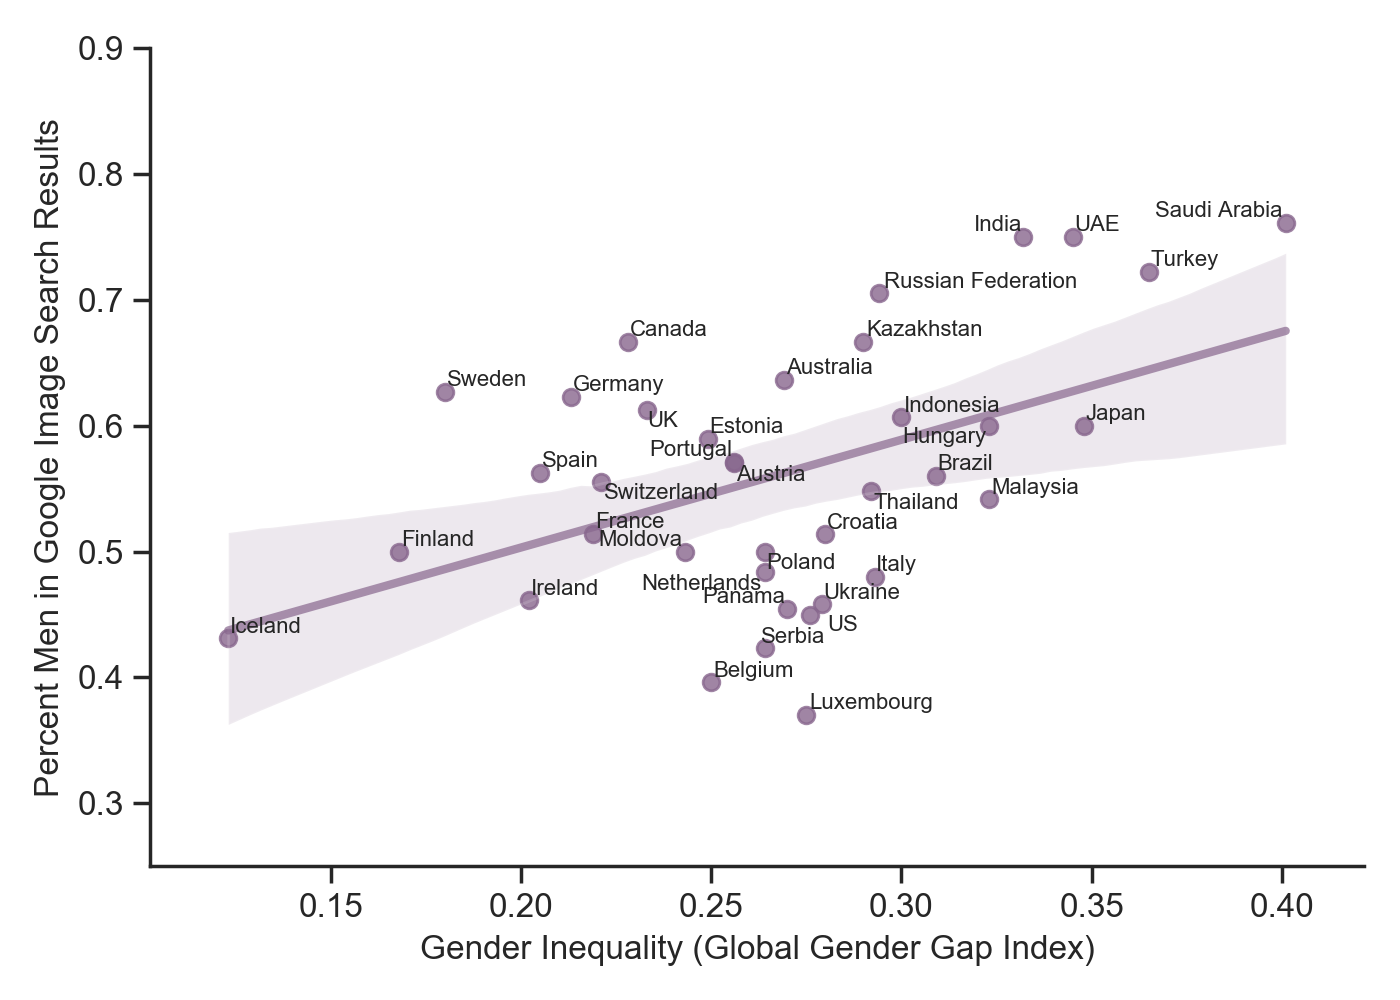

In [5]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

sns.regplot(x=df.GGG_inverse, y=df.PercentM, scatter_kws={"color": "#88678E"}, \
            line_kws={"color":"#88678E","alpha":0.7,"lw":3}, ax=ax)

X = df.GGG_inverse
Y = df.PercentM
T = df.Country
texthandles = [plt.text(X[i], Y[i], T[i], ha='center', va='center', fontsize=8) for i in range(df.shape[0])]
adjust_text(texthandles)
ax.set_ylabel('Percent Men in Google Image Search Results')
ax.set(xlabel='Gender Inequality (Global Gender Gap Index)')

plt.ylim(.25, .9)
sns.despine()
plt.tight_layout()
plt.savefig('Figure.pdf', format="pdf")

In [30]:
scaler = StandardScaler()
df[['GGG_inverse', 'PercentM']] = scaler.fit_transform(df[['GGG_inverse', 'PercentM']])
df.head()

,Country,Region,GGG,GGG_inverse,PercentF,PercentM,PercentWomen_population
0,Australia,AngloSaxon,0.731,0.024809,0.363636,0.746438,50.201238
1,Austria,NandWEurope,0.744,-0.209172,0.430000,0.087854,50.710000
2,Belgium,NandWEurope,0.750,-0.317163,0.603960,-1.638508,50.435502
3,Brazil,SouthAmerica,0.691,0.744748,0.439560,-0.007023,50.867485
4,Canada,AngloSaxon,0.772,-0.713129,0.333333,1.047162,50.368025


In [35]:
md = smf.ols(" PercentM ~ GGG_inverse ", df)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:               PercentM   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     10.03
Date:                Fri, 22 Apr 2022   Prob (F-statistic):            0.00319
Time:                        09:43:22   Log-Likelihood:                -47.839
No. Observations:                  37   AIC:                             99.68
Df Residuals:                      35   BIC:                             102.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.287e-15      0.149   8.64e-15      

In [34]:
md = smf.ols(" PercentM ~ GGG_inverse + PercentWomen_population", df)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:               PercentM   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     6.852
Date:                Fri, 22 Apr 2022   Prob (F-statistic):            0.00316
Time:                        09:39:47   Log-Likelihood:                -46.236
No. Observations:                  37   AIC:                             98.47
Df Residuals:                      34   BIC:                             103.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 